# The Challenge: Predicting Telecom Customer Churn

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve, auc)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set(style="whitegrid")

print("All libraries imported successfully!")

All libraries imported successfully!


## Load datasets

In [99]:
df = pd.read_csv(r'D:\DAU Notes\CORE ML\Assignments\LAB5\telecom_churn.csv')
df.shape


(100000, 12)

In [100]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerID       100000 non-null  object 
 1   Gender           81787 non-null   object 
 2   SeniorCitizen    81861 non-null   float64
 3   Partner          81994 non-null   object 
 4   Dependents       82003 non-null   object 
 5   Tenure           82001 non-null   float64
 6   PhoneService     82096 non-null   object 
 7   InternetService  81579 non-null   object 
 8   MonthlyCharges   81904 non-null   float64
 9   TotalCharges     80257 non-null   object 
 10  Churn            100000 non-null  object 
 11  Timestamp        81757 non-null   object 
dtypes: float64(3), object(9)
memory usage: 9.2+ MB
None


In [102]:
print(df.columns)

Index(['CustomerID', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Tenure', 'PhoneService', 'InternetService', 'MonthlyCharges',
       'TotalCharges', 'Churn', 'Timestamp'],
      dtype='object')


In [103]:
df.describe()

,SeniorCitizen,Tenure,MonthlyCharges
count,81861.000000,82001.000000,81904.000000
mean,0.149375,35.834831,69.052925
std,0.356460,20.977581,29.438206
min,0.000000,0.000000,18.010000
25%,0.000000,18.000000,43.640000
50%,0.000000,36.000000,68.990000
75%,0.000000,54.000000,94.610000
max,1.000000,72.000000,120.000000


## 2.Initial cleaning

In [104]:
non_numeric = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]
print(non_numeric[['CustomerID', 'TotalCharges']])

       CustomerID TotalCharges
0      CUST000001          NaN
8      CUST000009          NaN
16     CUST000017          NaN
27     CUST000028          NaN
31     CUST000032          NaN
...           ...          ...
99969  CUST099970          NaN
99974  CUST099975          NaN
99975  CUST099976          NaN
99989  CUST099990          NaN
99995  CUST099996          NaN

[20591 rows x 2 columns]


In [178]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [177]:
median_val  = train_df['TotalCharges'].median()
train_df['TotalCharges'].fillna(median_val, inplace=True)
test_df['TotalCharges'].fillna(median_val, inplace=True)
print(train_df[['CustomerID', 'TotalCharges']])
print(test_df[['CustomerID', 'TotalCharges']])

       CustomerID  TotalCharges
75220  CUST075221       2008.15
48955  CUST048956       7736.30
44966  CUST044967        159.45
13568  CUST013569       1061.30
92727  CUST092728       3342.11
...           ...           ...
6265   CUST006266        187.21
54886  CUST054887       2490.96
76820  CUST076821        607.75
860    CUST000861       1127.09
15795  CUST015796       1967.49

[80000 rows x 2 columns]
       CustomerID  TotalCharges
75721  CUST075722         19.26
80184  CUST080185       3155.35
19864  CUST019865       7736.16
76699  CUST076700       4236.71
92991  CUST092992       2008.15
...           ...           ...
32595  CUST032596        462.63
29313  CUST029314        420.65
37862  CUST037863       1619.36
53421  CUST053422       1926.50
42410  CUST042411       7110.82

[20000 rows x 2 columns]


In [107]:
missing_counts = df.isnull().sum()
missing_percent = (df.isnull().mean() * 100).round(2)
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percent': missing_percent
})
print(missing_summary)

                 Missing Values  Percent
CustomerID                    0     0.00
Gender                    18213    18.21
SeniorCitizen             18139    18.14
Partner                   18006    18.01
Dependents                17997    18.00
Tenure                    17999    18.00
PhoneService              17904    17.90
InternetService           18421    18.42
MonthlyCharges            18096    18.10
TotalCharges              20591    20.59
Churn                         0     0.00
Timestamp                 18243    18.24


In [10]:
df.dtypes

CustomerID          object
Gender              object
SeniorCitizen      float64
Partner             object
Dependents          object
Tenure             float64
PhoneService        object
InternetService     object
MonthlyCharges     float64
TotalCharges       float64
Churn               object
Timestamp           object
dtype: object

In [111]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print("Numeric values", num_cols)
print("Categoric values", cat_cols)

exclude_cols = ['CustomerID', 'Timestamp', 'Churn']
num_cols = [col for col in num_cols if col not in exclude_cols]
cat_cols = [col for col in cat_cols if col not in exclude_cols]
print("After removal:")
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric values ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']
Categoric values ['CustomerID', 'Gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'Churn', 'Timestamp']
After removal:
Numeric columns: ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['Gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService']


In [179]:
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        if train_df[col].dtype in ['int64', 'float64']:
            median_val = train_df[col].median()
            train_df[col].fillna(median_val, inplace=True)
            test_df[col].fillna(median_val, inplace=True)
        else:  # categorical
            mode_val = train_df[col].mode()[0]
            train_df[col].fillna(mode_val, inplace=True)
            test_df[col].fillna(mode_val, inplace=True)


In [180]:
print("Missing values for train:", train_df.isnull().sum().sum())
print("Missing values for test:", test_df.isnull().sum().sum())


Missing values for train: 0
Missing values for test: 0


## Exploratory Data Analysis (EDA)
### Data Visualization

## For Categorical Data

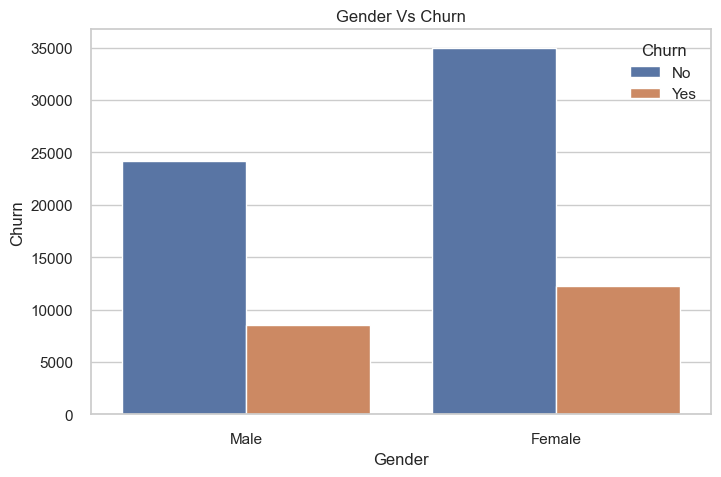

In [114]:
plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x="Gender", hue="Churn")
plt.title("Gender Vs Churn")
plt.xlabel("Gender")
plt.ylabel("Churn")
plt.show()

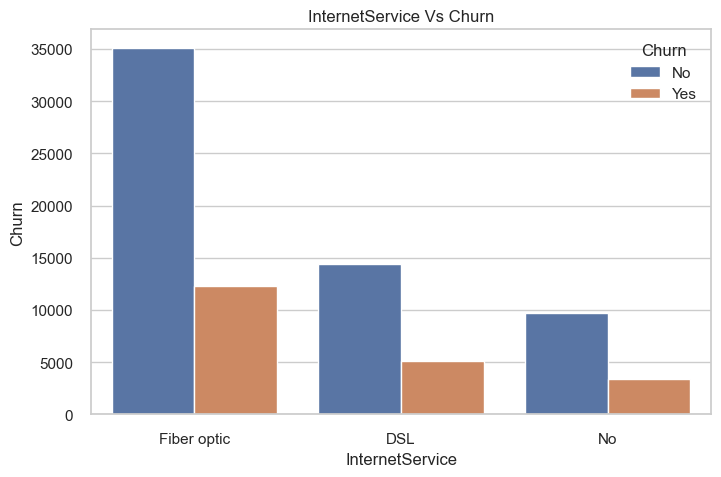

In [115]:
plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x="InternetService", hue="Churn")
plt.title("InternetService Vs Churn")
plt.xlabel("InternetService")
plt.ylabel("Churn")
plt.show()

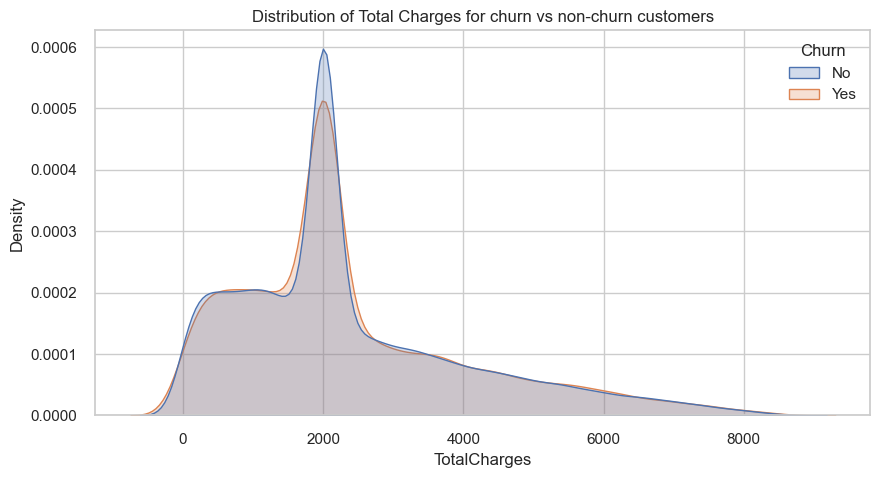

In [116]:
plt .figure(figsize=(10,5))
sns.kdeplot(data=train_df, x="TotalCharges", hue="Churn", fill=True, common_norm=False)
plt.title("Distribution of Total Charges for churn vs non-churn customers")
plt.xlabel("TotalCharges")
plt.ylabel("Density")
plt.show()


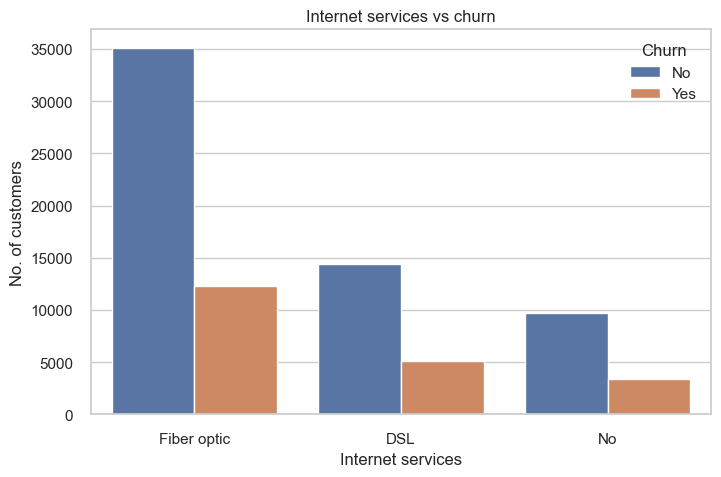

In [117]:
plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x="InternetService", hue="Churn")
plt.title("Internet services vs churn")
plt.xlabel("Internet services")
plt.ylabel("No. of customers")
plt.show()

## Numerical data

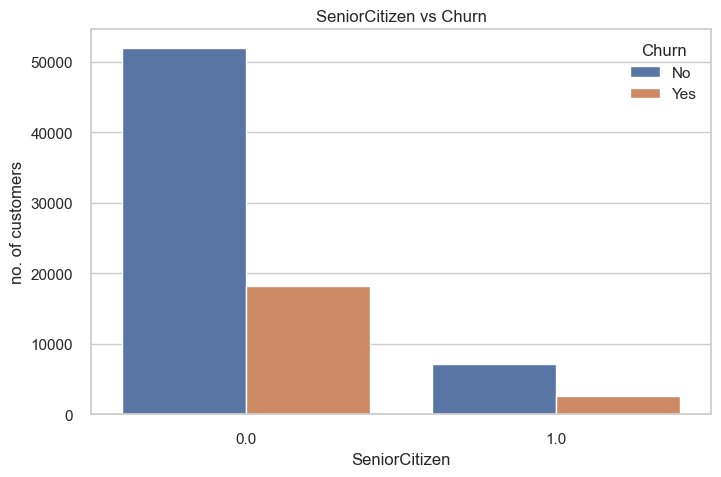

In [118]:
plt.figure(figsize=(8,5))
sns.countplot(data=train_df, x='SeniorCitizen', hue='Churn')
plt.title("SeniorCitizen vs Churn")
plt.xlabel('SeniorCitizen')
plt.ylabel('no. of customers')
plt.show()

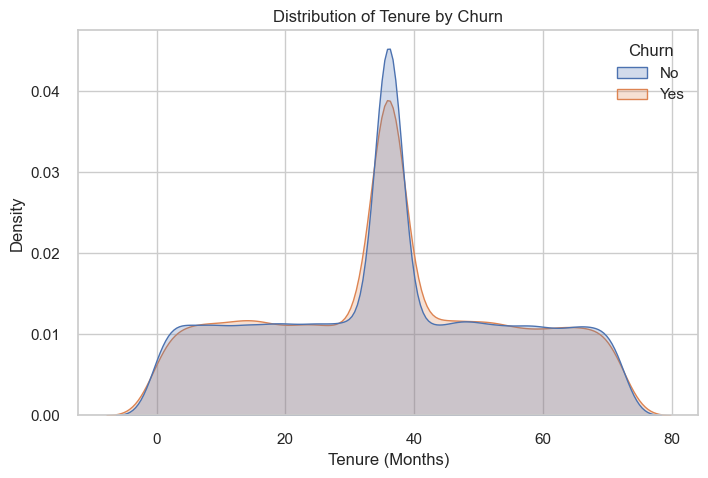

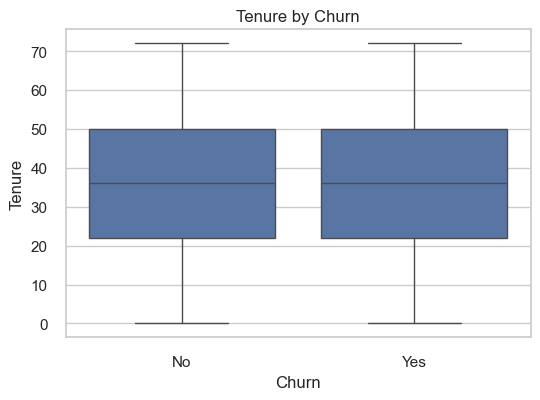

In [119]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=train_df, x="Tenure", hue="Churn", fill=True, common_norm=False)
plt.title("Distribution of Tenure by Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Density")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=train_df, x="Churn", y="Tenure")
plt.title("Tenure by Churn")
plt.show()


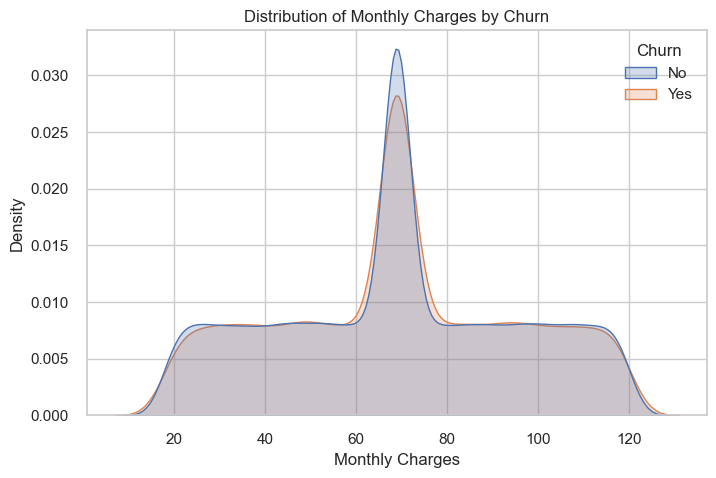

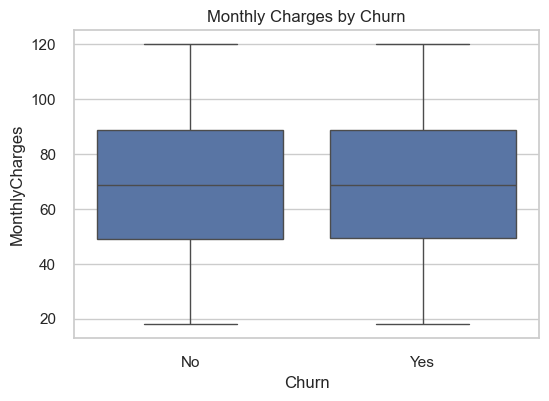

In [120]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=train_df, x="MonthlyCharges", hue="Churn", fill=True, common_norm=False)
plt.title("Distribution of Monthly Charges by Churn")
plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.show()

# Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=train_df, x="Churn", y="MonthlyCharges")
plt.title("Monthly Charges by Churn")
plt.show()


### Summarize your key findings from the EDA

In [121]:
len(train_df.columns), len(test_df.columns)

(12, 12)

In [122]:
print(pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)))

                 0
CustomerID       0
Gender           0
SeniorCitizen    0
Partner          0
Dependents       0
Tenure           0
PhoneService     0
InternetService  0
MonthlyCharges   0
TotalCharges     0
Churn            0
Timestamp        0


## Feature Engineering

In [151]:
train_df["AvgMonthlySpend"] = train_df["TotalCharges"] / (train_df["Tenure"] + 1)
test_df["AvgMonthlySpend"] = test_df["TotalCharges"] / (test_df["Tenure"] + 1)

In [152]:
train_df["TenureGroup"] = pd.cut(
    train_df["Tenure"],
    bins=[-1, 12, 24, 48, 72],
    labels=["0-1 yr", "1-2 yr", "2-4 yr", "4-6 yr"]
)

test_df["TenureGroup"] = pd.cut(
    test_df["Tenure"],
    bins=[-1, 12, 24, 48, 72],
    labels=["0-1 yr", "1-2 yr", "2-4 yr", "4-6 yr"]
)

## Justification of Feature Engineering
### For AvgMonthlySpend: 

### 1.It measure how much a customer spends on average per month 
### 2.Customer with high spend per month more likely to churn if they feel it's too expensive
### 3.Customer with low spend might be on minimal service and may also churn if they can't find value.

### For TenureGroup:
### 1.New customers (0-1yr) are usually at the higher risk of churn
### 2.Long term customers(4-6yrs) tend to be more loyal

## Task 3: Building the End-to-End Pipeline

In [153]:
X = train_df.drop("Churn", axis=1)
Y = train_df['Churn']

In [154]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
# Numeric pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [141]:
num_col = ['SeniorCitizen', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend']
cat_col = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'TenureGroup']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_col),
        ("cat", categorical_transformer,cat_col)

    ],
    remainder='drop'
)

In [155]:
train_df.isnull().sum()

CustomerID         0
Gender             0
SeniorCitizen      0
Partner            0
Dependents         0
Tenure             0
PhoneService       0
InternetService    0
MonthlyCharges     0
TotalCharges       0
Churn              0
Timestamp          0
AvgMonthlySpend    0
TenureGroup        0
dtype: int64

In [156]:
lg_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])


In [161]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [159]:
from sklearn.ensemble import GradientBoostingClassifier
gb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier',GradientBoostingClassifier(random_state=42))
])

In [160]:
X_train = train_df[num_cols + cat_cols]
Y_train = train_df['Churn']

In [162]:
# Logistic regression
lg_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'Tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgMonthlySpend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'InternetService',
                                                   'TenureGroup'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [163]:
# random forest
rf_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'Tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgMonthlySpend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'InternetService',
                                                   'TenureGroup'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [164]:
# Gradient boosting
gb_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'Tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgMonthlySpend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'InternetService',
                                                   'TenureGroup'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [165]:
X_test = test_df[num_col + cat_col]
y_test = test_df['Churn']

from sklearn.metrics import f1_score, classification_report, confusion_matrix

pipelines = {
    'Logistic Regression': lg_pipeline,
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline
}

for name, pipe in pipelines.items():
    y_pred = pipe.predict(X_test)
    print(f"--- {name} ---")
    print("F1 Score (weighted):", f1_score(y_test, y_pred, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("\n")


--- Logistic Regression ---
F1 Score (weighted): 0.6262797715305153
Confusion Matrix:
 [[14753     0]
 [ 5247     0]]
Classification Report:
               precision    recall  f1-score   support

          No       0.74      1.00      0.85     14753
         Yes       0.00      0.00      0.00      5247

    accuracy                           0.74     20000
   macro avg       0.37      0.50      0.42     20000
weighted avg       0.54      0.74      0.63     20000



--- Random Forest ---
F1 Score (weighted): 0.6367059974603351
Confusion Matrix:
 [[13037  1716]
 [ 4621   626]]
Classification Report:
               precision    recall  f1-score   support

          No       0.74      0.88      0.80     14753
         Yes       0.27      0.12      0.16      5247

    accuracy                           0.68     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.61      0.68      0.64     20000



--- Gradient Boosting ---
F1 Score (weighted): 0.626226594058465

In [167]:
# Pipeline with class_weight='balanced'
class_weight_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train
class_weight_pipeline.fit(X_train, Y_train)

# Predict
y_pred_weight = class_weight_pipeline.predict(X_test)

# Evaluate
print("=== Class Weighting ===")
print("F1 Score (weighted):", f1_score(y_test, y_pred_weight, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_weight))
print("Classification Report:\n", classification_report(y_test, y_pred_weight))


=== Class Weighting ===
F1 Score (weighted): 0.634986126847081
Confusion Matrix:
 [[13022  1731]
 [ 4636   611]]
Classification Report:
               precision    recall  f1-score   support

          No       0.74      0.88      0.80     14753
         Yes       0.26      0.12      0.16      5247

    accuracy                           0.68     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.61      0.68      0.63     20000



In [168]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),   # preprocessing numeric + categorical
    ('smote', SMOTE(random_state=42)),  # oversample minority class
    ('classifier', RandomForestClassifier(random_state=42))
])


In [170]:
smote_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'Tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'AvgMonthlySpend']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'InternetService',
                                                   'TenureGroup'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [171]:
y_pred_smote = smote_pipeline.predict(X_test)

In [172]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print("=== SMOTE Oversampling ===")
print("F1 Score (weighted):", f1_score(y_test, y_pred_smote, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("Classification Report:\n", classification_report(y_test, y_pred_smote))


=== SMOTE Oversampling ===
F1 Score (weighted): 0.6082524146649275
Confusion Matrix:
 [[10590  4163]
 [ 3763  1484]]
Classification Report:
               precision    recall  f1-score   support

          No       0.74      0.72      0.73     14753
         Yes       0.26      0.28      0.27      5247

    accuracy                           0.60     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.61      0.60      0.61     20000



In [ ]:
##Observations:
## Baseline: i'll just say nobody will leave. --> easy, but useless.
## Class weighting: pay a little more attention to people who might leave. --> small improvement.
## SMOTE: show more example of people leaving, so i can spot them better. -->
##much better at finding churners, even if it makes some mistakes elsewhere.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
y_pred = smote_pipeline.predict(X_test)
y_proba = smote_pipeline.predict_proba(X_test)[:, 1] 
precision = precision_score(y_test, y_pred, pos_label='Yes')
recall = recall_score(y_test, y_pred, pos_label='Yes')
f1 = f1_score(y_test, y_pred, pos_label='Yes')
roc_auc = roc_auc_score(y_test.map({'No':0,'Yes':1}), y_proba)

print("Precision (Yes):", precision)
print("Recall (Yes):", recall)
print("F1-Score (Yes):", f1)
print("ROC AUC:", roc_auc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(y_test, y_pred))


Precision (Yes): 0.2627944041083761
Recall (Yes): 0.2828282828282828
F1-Score (Yes): 0.2724435469065541
ROC AUC: 0.5005949825647514
Confusion Matrix:
 [[10590  4163]
 [ 3763  1484]]
Classification Report:
               precision    recall  f1-score   support

          No       0.74      0.72      0.73     14753
         Yes       0.26      0.28      0.27      5247

    accuracy                           0.60     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.61      0.60      0.61     20000



Top 10 Important Features:
 MonthlyCharges                 0.271174
AvgMonthlySpend                0.236406
TotalCharges                   0.216042
Tenure                         0.188830
SeniorCitizen                  0.012904
InternetService_Fiber optic    0.007215
Partner_Yes                    0.007089
Partner_No                     0.007084
InternetService_DSL            0.006486
Gender_Male                    0.006410
dtype: float64


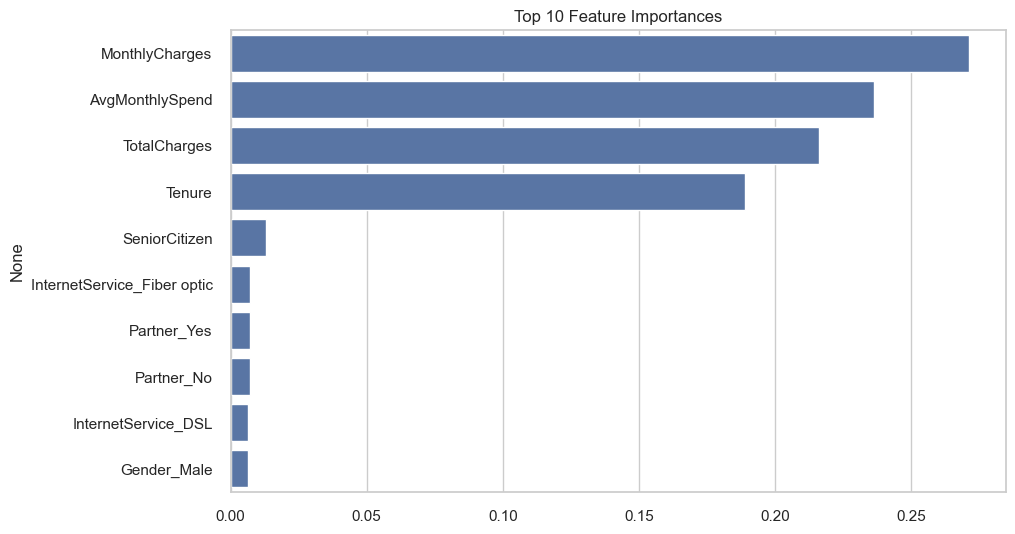

In [176]:
# Get feature names after preprocessing
num_features = num_col 
cat_features = list(smote_pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out(cat_col)) 

all_features = num_features + cat_features

rf_model = smote_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_

feat_importances = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Top 10 features
top10 = feat_importances.head(10)
print("Top 10 Important Features:\n", top10)
plt.figure(figsize=(10,6))
sns.barplot(x=top10.values, y=top10.index)
plt.title("Top 10 Feature Importances")
plt.show()
